# Overview

In [1]:
from score_models.plot_utils import *
from score_models.toy_distributions import *
import torch
plt.style.use("dark_background")

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Training an SBM

### Dataset

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    Example of a dataset class. For more realistics cases, 
    one would load the data from a file or a database. Here 
    we assume the data is already loaded in memory.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [3]:
D = int(2**12)

# Example of a dataset with a 2D distribution
distribution = swiss_roll()
data = distribution.sample((D,))
dataset = Dataset(data)

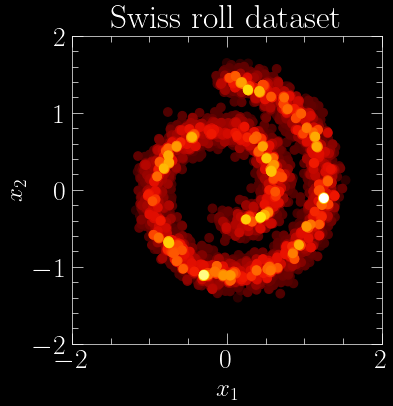

In [4]:
extent = (-2, 2, -2, 2)

ax = plot_scatter(data, bins=100, extent=extent)
ax.set_title("Swiss roll dataset")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

### Neural Network Architecture

In [5]:
from score_models import MLP

C = 2 # 2D dataset
layers = 2
width = int(2**7)

net = MLP(C, layers=layers, width=width, fourier_scale=0.02)

### Perturbation Kernel

In [6]:
from score_models import VESDE

 # These hyperparameters are dependent on the dataset, and should be tuned
sigma_min = 1e-2
sigma_max = 2
sde = VESDE(sigma_min=sigma_min, sigma_max=sigma_max)

### Fitting the SBM

In [7]:
from score_models import ScoreModel

E = 400
B = int(2**7)
lr = 1e-3
# ema_decay = 0.99
ema_lengths = 0.05

model = ScoreModel(net, sde)
losses = model.fit(dataset, epochs=E, batch_size=B, learning_rate=lr, ema_lengths=ema_lengths)

MLP network has 0.10M parameters.
Using Karras EMA with ema lengths [0.05]
No path provided. Training checkpoints will not be saved.


Epoch 400 | Cost: 7.0e-01 |: 100%|██████████| 400/400 [01:04<00:00,  6.23it/s]

Finished training after 0.018 hours.


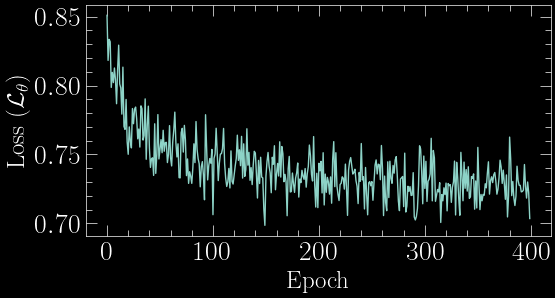

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.ylabel(r"Loss ($\mathcal{L}_\theta$)")
plt.xlabel("Epoch");

### Sampling from the SBM

In [9]:
N = int(2**12)
samples = model.sample(shape=(N, C), steps=100)

t=0.01 | sigma=0.01 | x=0.1±0.7: 100%|██████████| 100/100 [00:01<00:00, 83.56it/s]


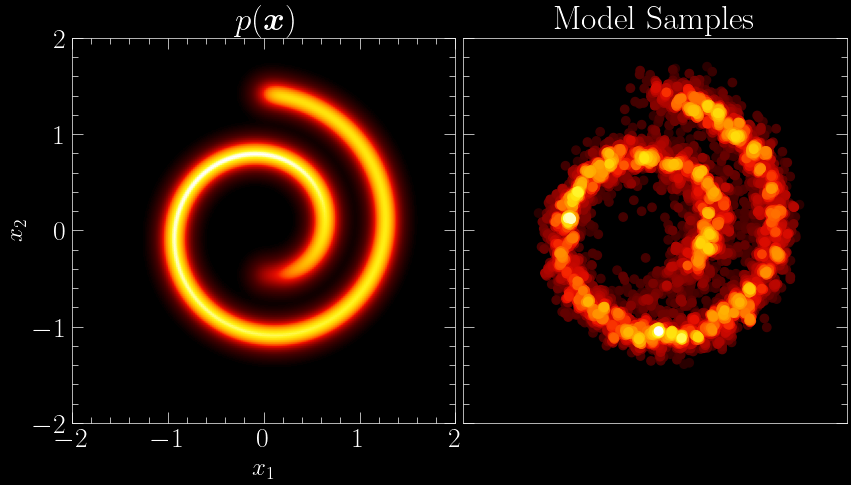

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
extent = (-2, 2, -2, 2)

plot_density(distribution.log_prob, ax=ax0, extent=extent, bins=200)
ax0.set_title(r"$p(\bm{x})$")
ax0.set_ylabel(r"$x_2$")
ax0.set_xlabel(r"$x_1$")

plot_scatter(samples, bins=50, ax=ax1, extent=extent)
ax1.set_title("Model Samples")
ax1.set_xticks([])

plt.subplots_adjust(wspace=0.02)